### Jack Risse
### Module 3 Project
### October 28, 2019

## Hypothesis 1
#### Null Hypothesis: 
The quantity of a product in an order when no discount is given will be <strong>equal</strong> to the quantity of a product in an order when a discount is given.



#### Alternative Hypothesis:
The quantity of a product in an order when no discount is given will be <strong>less</strong> than the quantity of a product in an order when a discount is given. At what discount level is the most significant?

In [1]:
import sqlite3 # query and connecting through databases
import funcs # custom module 
import warnings # ingores all the annoying matplotlib warnings

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import Normalizer, MinMaxScaler
from scipy.stats import norm, jarque_bera, ttest_ind, f_oneway

warnings.filterwarnings('ignore')

DB = 'Northwind_small.sqlite' # database that was given

In [2]:
query = 'select OrderId, ProductId, Quantity, Discount, UnitPrice from OrderDetail order by ProductId;'
h1 = funcs.sql_to_df(DB, query)
h1.head()

,OrderId,ProductId,Quantity,Discount,UnitPrice
0,10285,1,45,0.20,14.4
1,10294,1,18,0.00,14.4
2,10317,1,20,0.00,14.4
3,10348,1,15,0.15,14.4
4,10354,1,12,0.00,14.4


In [3]:
h1.describe()

,OrderId,ProductId,Quantity,Discount,UnitPrice
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,23.812993,0.056167,26.218520
std,241.378032,22.159019,19.022047,0.083450,29.827418
min,10248.000000,1.000000,1.000000,0.000000,2.000000
25%,10451.000000,22.000000,10.000000,0.000000,12.000000
50%,10657.000000,41.000000,20.000000,0.000000,18.400000
75%,10862.500000,60.000000,30.000000,0.100000,32.000000
max,11077.000000,77.000000,130.000000,0.250000,263.500000


### Feature Engineering

-------darker shades of orange means that the grey bar is under the orange-------


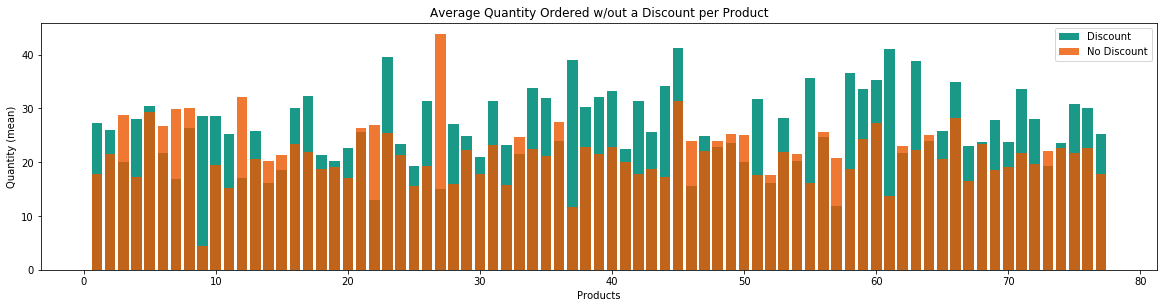

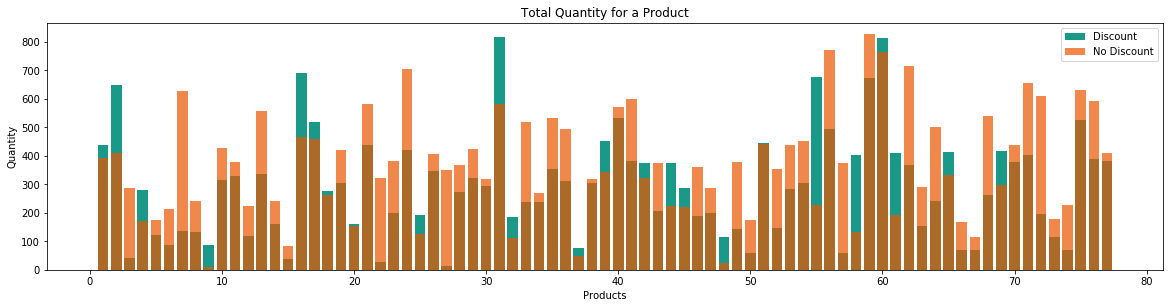

In [4]:
"""
for loops to count how much of a product was ordered 
when a discount is applied and when a discount wasn't 
applied
"""

disc_counts = []
for i in range(1, len(h1['ProductId'].unique())+1):
    df = h1.loc[(h1['Discount'] > 0) & (h1['ProductId'] == i)]
    count = df['Quantity'].values.sum()
    disc_counts.append(count)

no_disc_counts = []
for i in range(1, len(h1['ProductId'].unique())+1):
    df = h1.loc[(h1['Discount'] == 0) & (h1['ProductId'] == i)]
    count = df['Quantity'].values.sum()
    no_disc_counts.append(count)
    
"""finds the average quantity of a product for each order"""

discount_mu = h1[h1['Discount']!=0].groupby('ProductId')['Quantity'].mean()
no_discount_mu = h1[h1['Discount']==0].groupby('ProductId')['Quantity'].mean()
    
"""graphs the two comparisions above"""
print('-------darker shades of orange means that the grey bar is under the orange-------')
fig = plt.figure(figsize=(20,10))    
plt.subplot(211)
plt.bar(discount_mu.index, discount_mu.values, alpha=1, label='Discount', color='#1a9988ff')
plt.bar(no_discount_mu.index, no_discount_mu.values, alpha=0.8, label='No Discount', color='#eb5600ff')
plt.title('Average Quantity Ordered w/out a Discount per Product')
plt.xlabel('Products')
plt.ylabel('Quantity (mean)')
plt.legend()
plt.show()
fig = plt.figure(figsize=(20,10))
plt.subplot(212)
plt.bar(h1['ProductId'].unique(), disc_counts, alpha=1, color='#1a9988ff', label='Discount')
plt.bar(h1['ProductId'].unique(), no_disc_counts, alpha=.7, color='#eb5600ff', label='No Discount')
plt.title('Total Quantity for a Product')
plt.xlabel('Products')
plt.ylabel('Quantity')
plt.legend()
plt.show()

In [5]:
h1['bi_Discount'] = h1['Discount'].apply(lambda x: 1 if x > 0 else 0) 

In [6]:
h1.head()

,OrderId,ProductId,Quantity,Discount,UnitPrice,bi_Discount
0,10285,1,45,0.20,14.4,1
1,10294,1,18,0.00,14.4,0
2,10317,1,20,0.00,14.4,0
3,10348,1,15,0.15,14.4,1
4,10354,1,12,0.00,14.4,0


In [7]:
discount, quantity = h1['Discount'], h1['Quantity']
q_mean, q_std = np.mean(quantity), np.var(quantity, ddof=1)
d_mean, d_std = np.mean(discount), np.var(discount, ddof=1)
q_n, d_n = len(quantity), len(discount)

# testing for the normality assumption
print("(stat, pvalue):\n", jarque_bera(discount), jarque_bera(quantity))

(stat, pvalue):
 (523.7128429494181, 0.0) (3030.5195586308337, 0.0)


The jarque_bera test tests for normality in our distribution, typically used for large samples. A large J-B value usually means that the distribution of our sample isn't normal.

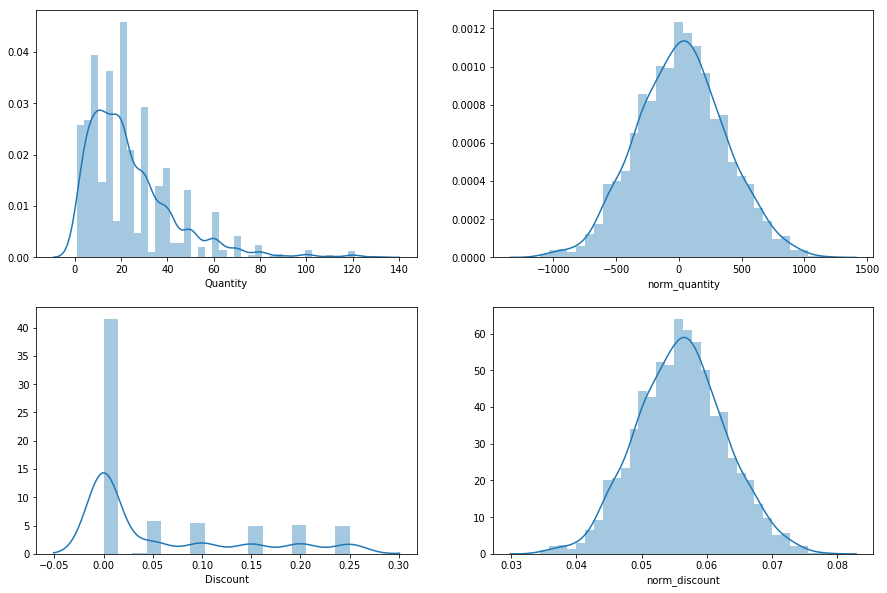

In [8]:
"""Creating a normal distribution that represents the data in hand"""

h1['norm_quantity'], h1['norm_discount'] = norm.rvs(loc=q_mean, scale=q_std, size=q_n, random_state=0), norm.rvs(loc=d_mean, scale=d_std, size=d_n, random_state=0)

fig = plt.figure(figsize=(15,10))
plt.subplot(221)
sns.distplot(quantity)
plt.subplot(222)
sns.distplot(h1['norm_quantity'])
plt.subplot(223)
sns.distplot(discount)
plt.subplot(224)
sns.distplot(h1['norm_discount'])

Our transformation seemed to be successful in creating a normal distribution that represents our data in hand.

In [9]:
"""
Let's test if there's a statistical significance between 
discount and no discount with Welchs t-test because we want 
to see if they are equal (two-tailed) and the variance's of 
two aren't similar.
"""

discount = h1[h1["Discount"]!=0]["Quantity"] # experimental
no_discount = h1[h1["Discount"]==0]["Quantity"] # control

t, p = ttest_ind(discount, no_discount)
d = funcs.Cohen_d(discount, no_discount)
print('T-stat: {}\np-value: {}\n'.format(t,p), "CohensD: {}".format(d))

T-stat: 6.478563196294901
p-value: 1.1440924523215966e-10
 CohensD: 0.2862724481729282


## Results
The null hypothesis ended up being rejected. Alpha was set to .05 or 5%. The general rule to decide if the null hypothesis will be rejected or not is if the p-value is less than the set alpha. Even though the null hypothesis was rejected, the Cohens D score indicates that a discount doesn't effect the quantity of a product being ordered.

In [10]:
groups = (h1.Discount == 0.05) | (h1.Discount == 0.10) | (h1.Discount == 0.15) | (h1.Discount == 0.20) | (h1.Discount == 0.25)
h1 = h1.loc[groups] # discounts of 1% 2% 3% 4% 6% had insuffiecnt data so they were not taken into account

group_h1 = h1.groupby('Discount')['OrderId'].agg(['count'])
group_h12 = h1.groupby('Discount')['Quantity'].agg(['mean', 'sum'])

Text(0, 0.5, 'Average Quantity')

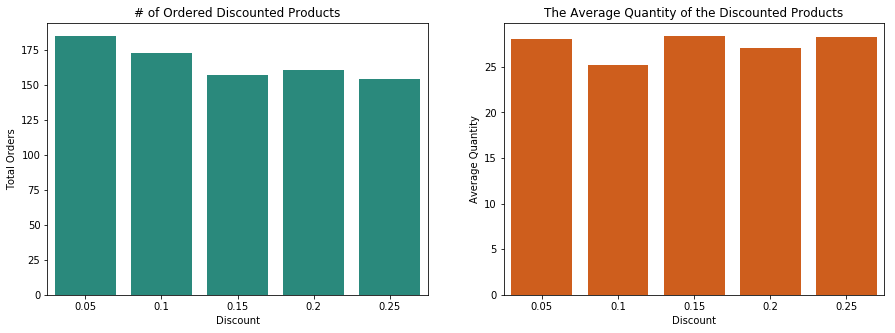

In [11]:
fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.barplot(group_h1.index, group_h1['count'], color='#1a9988ff')
plt.title('# of Ordered Discounted Products')
plt.ylabel('Total Orders')
plt.subplot(122)
sns.barplot(group_h12.index, group_h12['mean'], color='#eb5600ff')
plt.title('The Average Quantity of the Discounted Products')
plt.ylabel('Average Quantity')

If a discount was given, the <strong>products with 5% off</strong> seemed be the one that thrived when the discount was given.

## Hypothesis 2
I wanted to see if the price of the product was effected on where the product was coming from. Due to not enough of data and no comparison to products from different locations.

In [12]:
query = """select p.SupplierId, p.ProductName, p.UnitPrice, s.Country 
           from Product as p 
           left join Supplier as s 
           on p.SupplierId = s.Id;"""
h2 = funcs.sql_to_df(DB, query)
h2.head()

,SupplierId,ProductName,UnitPrice,Country
0,1,Chai,18.00,UK
1,1,Chang,19.00,UK
2,1,Aniseed Syrup,10.00,UK
3,2,Chef Anton's Cajun Seasoning,22.00,USA
4,2,Chef Anton's Gumbo Mix,21.35,USA


In [13]:
h2_countries = h2.groupby('Country')['UnitPrice'].agg(['mean', 'sum'])
h2_countries['ProductCount'] = h2['Country'].value_counts()
h2_countries.add_prefix('UnitPrice_')
h2_countries

,mean,sum,ProductCount
Country,,,
Australia,33.831250,270.65,8
Brazil,4.500000,4.50,1
Canada,27.312500,109.25,4
Denmark,10.750000,21.50,2
Finland,18.083333,54.25,3
France,76.750000,383.75,5
Germany,37.601111,338.41,9
Italy,27.360000,136.80,5
Japan,30.458333,182.75,6


Text(0.5, 1.0, 'Average Price of Products Out of a Country')

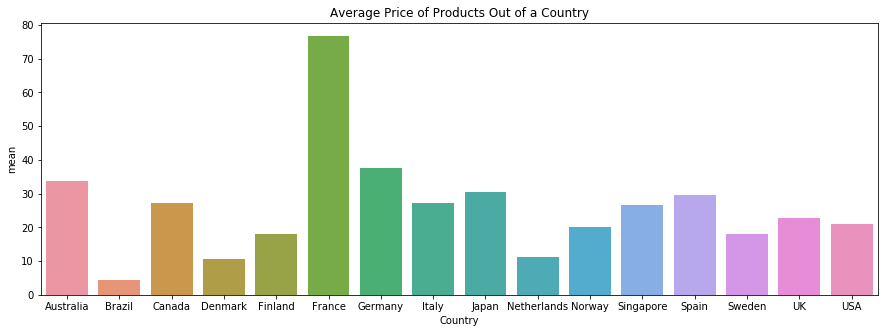

In [14]:
fig = plt.figure(figsize=(15,5))
sns.barplot(h2_countries.index, h2_countries['mean'])
plt.title('Average Price of Products Out of a Country')

In [15]:
ext_data = {}

In [16]:
for country in h2["Country"].unique():
    data = h2.loc[(h2['Country']==country)]['UnitPrice']
    if len(data) >= 3:
        boot = funcs.bootstrap(data, 30)
        ext_data[country] = boot

In [17]:
for k,v in ext_data.items():
    ext_data[k] = v[0]

ext_df = pd.DataFrame(ext_data)

### Hypothesis 3
#### Null Hypothesis:
There isn't a significant statistical difference between the total revenue brought in per employee.
#### Alternative Hypothesis:
There is a significant statistical difference between the total revenue brought in per employee.

In [18]:
query = '''select o.Id, 
               o.EmployeeId, 
               e.Region, 
               sum((od.UnitPrice * (1 - od.Discount)) * od.Quantity) OrderPrice 
           from [Order] o 
           join Employee e 
           on e.Id = o.EmployeeId
           join OrderDetail od
           on o.Id = od.OrderId
           group by o.Id;'''

h3 = funcs.sql_to_df(DB, query)
h3.head()

,Id,EmployeeId,Region,OrderPrice
0,10248,5,British Isles,440.00
1,10249,6,British Isles,1863.40
2,10250,4,North America,1552.60
3,10251,3,North America,654.06
4,10252,4,North America,3597.90


The OrderPrice column represents the amount of money for a single order.

Text(0.5, 0, 'Employee')

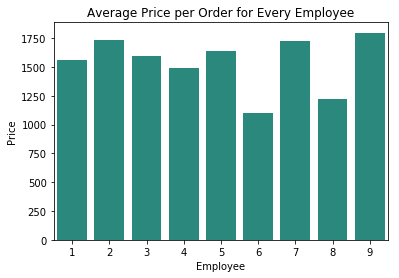

In [26]:
y = h3.groupby('EmployeeId')['OrderPrice'].mean() # mean of the total amount of money was calculated for each employee
sns.barplot(y.index, y, color='#1a9988ff')
plt.title('Average Price per Order for Every Employee')
plt.ylabel('Price')
plt.xlabel('Employee')

In [20]:
"""
ANOVA test was used to compare multiple employees 
production to save time from testing all of the 
possible combinations comparing each employee to 
each employe
"""

formula = 'OrderPrice ~ C(EmployeeId)'
lm = smf.ols(formula, h3).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                     sum_sq     df        F    PR(>F)
C(EmployeeId)  3.358256e+07    8.0  1.23576  0.274783
Residual       2.788901e+09  821.0      NaN       NaN


## Results
The ANOVA test chosen because the hypothesis called for comparing multiple samples not just two. If there were just two employees then a t-test would have been sufficient. The F-stat is the significant statistic when using the ANOVA test. Since the p-value is greater than the set significance level, the null hypothesis failed to be rejected. 

## Hypothesis 4
#### Null Hypothesis:
There isn't a significant statistical difference between the revenue brought in per Office.
#### Alternative Hypothesis:
There is a significant statistical difference between the revenue brought in per Office.

In [21]:
h3.head()

,Id,EmployeeId,Region,OrderPrice
0,10248,5,British Isles,440.00
1,10249,6,British Isles,1863.40
2,10250,4,North America,1552.60
3,10251,3,North America,654.06
4,10252,4,North America,3597.90


In [22]:
group_h3 = h3.groupby('Region')['OrderPrice'].agg(['sum', 'mean'])

Text(0, 0.5, 'Average Price per Order')

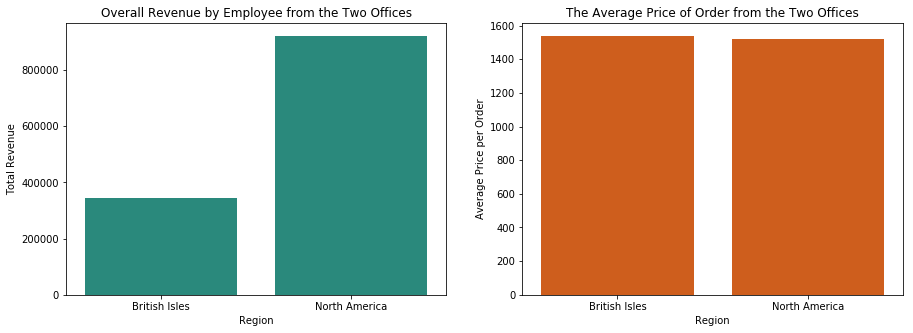

In [35]:
fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.barplot(group_h3.index, group_h3['sum'], color='#1a9988ff')
plt.title('Overall Revenue by Employee from the Two Offices')
plt.ylabel('Total Revenue')
plt.subplot(122)
sns.barplot(group_h3.index, group_h3['mean'], color='#eb5600ff')
plt.title('The Average Price of Order from the Two Offices')
plt.ylabel('Average Price per Order')

In [25]:
seatle = h3.loc[h3['Region']=='North America']['OrderPrice'] 
london = h3.loc[h3['Region']=='British Isles']['OrderPrice']

t, p = ttest_ind(seatle, london)
d = funcs.Cohen_d(seatle, london)
print('T-stat: {}\np-value: {}\n'.format(t,p), "CohensD: {}".format(d))

T-stat: -0.1257920376990191
p-value: 0.8999270811672749
 CohensD: 0.009836113809944588


## Results
The null hypothesis failed to be rejected indicated by the large p-value. If the total number of orders proccessed by each office was observed, your conclusion would be that the Seatle office out performs the London office. What that observation doesn't take into account is the population of consumers are different. The London office just may not get as many orders than the Seatle office does. That's is why average profit for each order in the different offices was the comparing stat because it compares them on an even playing field. But in conclusion both offices bring in the same impact.